# Specviz Simple Demo

**Use case:** This notebook demonstrates how to inspect spectra in Specviz, export spectra from the GUI in the notebook, select regions in the GUI and in the notebook, and measure the redshift of a source in the GUI.<br>
**Data:** NIRISS 1D spectra from the [NGDEEP survey](https://ui.adsabs.harvard.edu/abs/2023arXiv230205466B/abstract). The dataset is directly obtain from MAST after the default JWST pipeline processing.<br>
**Tools:** specutils, jdaviz.<br>
**Cross-intrument:** all instruments.<br>
**Documentation:** This notebook is part of a STScI's larger [post-pipeline Data Analysis Tools Ecosystem](https://jwst-docs.stsci.edu/jwst-post-pipeline-data-analysis).<br>

**Updated on**: 2023/10/11

In [1]:
# To use 100% of the browser window
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

Imports:
- matplotlib for plotting data
- astropy for handling of fits files, units, and tables
- specutils for interactions with Specviz and region definition/extraction
- jdaviz for the visualization tool Specviz

In [2]:
# Plotting and tabling
import matplotlib.pyplot as plt

# Import astropy
import astropy
import astropy.units as u
from astropy.io import fits
from astropy.nddata import StdDevUncertainty
from astropy.table import QTable

# Import specutils
import specutils
from specutils import Spectrum1D, SpectralRegion
from specutils.manipulation import extract_region

# Import viztools
import jdaviz
from jdaviz import Specviz

In [3]:
# Customization of matplotlib style
plt.rcParams["figure.figsize"] = (10, 5)
params = {'legend.fontsize': '18', 'axes.labelsize': '18',
          'axes.titlesize': '18', 'xtick.labelsize': '18',
          'ytick.labelsize': '18', 'lines.linewidth': 2,
          'axes.linewidth': 2, 'animation.html': 'html5',
          'figure.figsize': (8, 6)}
plt.rcParams.update(params)
plt.rcParams.update({'figure.max_open_warning': 0})

Check versions

In [4]:
print('astropy:', astropy.__version__)
print('specutils:', specutils.__version__)
print('jdaviz:', jdaviz.__version__)

astropy: 5.3.4
specutils: 1.12.0
jdaviz: 3.7.1


## 1. Load NIRISS pipeline output
The JWST/NIRISS data are stored on box. We work with the x1d file which contains all extracted 1D spectra.

In [5]:
filelink = 'https://data.science.stsci.edu/redirect/JWST/jwst-data_analysis_tools/specviz_notebook_gui_interaction/jw02079004002_11101_00001_nis_x1d.fits'
hdu = fits.open(filelink)

hdu.info()

Filename: /home/runner/.astropy/cache/download/url/cb25b167f5e051a9e693b45b4a9d0bba/contents
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     350   ()      
  1  EXTRACT1D     1 BinTableHDU     76   180R x 18C   [D, D, D, D, D, D, D, D, D, D, D, J, D, D, D, D, D, D]   
  2  EXTRACT1D     2 BinTableHDU     76   200R x 18C   [D, D, D, D, D, D, D, D, D, D, D, J, D, D, D, D, D, D]   
  3  EXTRACT1D     3 BinTableHDU     76   160R x 18C   [D, D, D, D, D, D, D, D, D, D, D, J, D, D, D, D, D, D]   
  4  EXTRACT1D     4 BinTableHDU     76   182R x 18C   [D, D, D, D, D, D, D, D, D, D, D, J, D, D, D, D, D, D]   
  5  EXTRACT1D     5 BinTableHDU     76   180R x 18C   [D, D, D, D, D, D, D, D, D, D, D, J, D, D, D, D, D, D]   
  6  EXTRACT1D     6 BinTableHDU     76   185R x 18C   [D, D, D, D, D, D, D, D, D, D, D, J, D, D, D, D, D, D]   
  7  EXTRACT1D     7 BinTableHDU     76   151R x 18C   [D, D, D, D, D, D, D, D, D, D, D, J, D, D, D, D, D, D]   
  8

## 2. Open Specviz and load the 1D spectra we are interested in

In [6]:
viz = Specviz()
viz.show()

Application(config='specviz', docs_link='https://jdaviz.readthedocs.io/en/v3.7.1/specviz/index.html', events=[…

The following cell opens one extension of the x1d file (75), creates a Spectrum1D object, and loads it into Specviz. A mask is set to only keep the part of the spectra with good sensitivity (1.34 to 1.66 micron) in the F150W filter.

In [7]:
for i in range(74, 75):
    spec_load = hdu[i+1].data
    wave = spec_load['WAVELENGTH']
    flux = spec_load['FLUX']
    error = spec_load['FLUX_ERROR']
    # mask the parts where the sensitivity in the bandpass is poor
    mask = ((wave > 1.34) & (wave < 1.66))
    spec1d = Spectrum1D(spectral_axis=wave[mask]*u.um, 
                        flux=flux[mask]*u.Jy, 
                        uncertainty=StdDevUncertainty(error[mask]*u.Jy)) #
    
    viz.load_data(spec1d, "NIRISS 1D {}".format(str(i+1)))

## 3. Select the emission lines using the GUI and in the notebook
I select the region spanning the emission lines from roughly 1.58 to 1.63 microns.

Instructions: https://jdaviz.readthedocs.io/en/latest/specviz/displaying.html#defining-spectral-regions

### See what data is used in this specviz istance

In [8]:
dataout = viz.get_spectra(apply_slider_redshift=False)
spec1d_line = dataout["NIRISS 1D 75"]

In [9]:
print(spec1d_line)

Spectrum1D (length=69)
flux:             [ 1.6163e-06 Jy, ..., 2.6548e-06 Jy ],  mean=3.4997e-06 Jy
spectral axis:    [ 1.6593 um, ..., 1.3403 um ],  mean=1.4998 um
uncertainty:      [ StdDevUncertainty(1.28849383e-07), ..., StdDevUncertainty(9.87921686e-08) ]


### See the subsets defined in the GUI
I include a try-except in case the notebook is run without human interaction.

In [10]:
try:
    region = viz.get_spectral_regions()
    print(region['Subset 1'])
except KeyError:
    print("No region defined in the GUI")

No region defined in the GUI


### Select the same region programmatically
I can define my own region (cont_region) between arbitrary bounds. I choose 1.598um and 1.621um. I can then extract the spectrum in that region.

In [11]:
cont_region = SpectralRegion(1.598*u.um, 1.621*u.um)
spec1d_el_code = extract_region(spec1d_line, cont_region)
print(spec1d_el_code)

Spectrum1D (length=5)
flux:             [ 5.2924e-06 Jy, ..., 5.8119e-06 Jy ],  mean=8.3154e-06 Jy
spectral axis:    [ 1.6171 um, ..., 1.5983 um ],  mean=1.6077 um
uncertainty:      [ StdDevUncertainty(1.16859251e-07), ..., StdDevUncertainty(1.15005193e-07) ]


Or I can extract the spectrum in the region I defined in the GUI (region['Subset 1']).

In [12]:
try:
    spec1d_el_viz = extract_region(spec1d_line, region['Subset 1'])
    print(spec1d_el_viz)
except KeyError:
    print("Region was not defined in the GUI")
    # Define spec1d_el_viz as spec1d_el_code
    spec1d_el_viz = spec1d_el_code

Region was not defined in the GUI


### Plot the spectrum and the subset with matplotlib

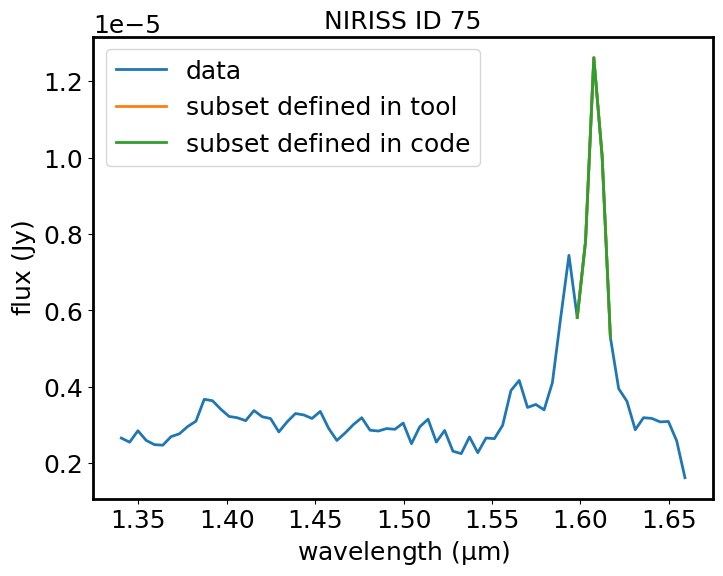

In [13]:
plt.plot(spec1d_line.spectral_axis, spec1d_line.flux, label='data')
plt.plot(spec1d_el_viz.spectral_axis, spec1d_el_viz.flux, label='subset defined in tool')
plt.plot(spec1d_el_code.spectral_axis, spec1d_el_code.flux, label='subset defined in code')
plt.legend()
plt.xlabel("wavelength ({:latex})".format(spec1d_line.spectral_axis.unit))
plt.ylabel("flux ({:latex})".format(spec1d_line.flux.unit))
plt.title("NIRISS ID 75")
plt.show()

## 4. Use the redshift slider in Specviz to find the redshift

I start by opening a new instance of Specviz so that I do not have to scroll up and down too much.

In [14]:
viz2 = Specviz()
viz2.show()

Application(config='specviz', docs_link='https://jdaviz.readthedocs.io/en/v3.7.1/specviz/index.html', events=[…

I load just the interesting spectrum (spec1d_line).

In [15]:
viz2.load_data(spec1d_line, "NIRISS 1D lines")

I can use an available line lists or define my own lines (I know I need Hb4861.3 and the [OIII]4958.9,5006.8 doublet) and play with the redshift slider to match the lines in the line list with the lines in the spectrum. The line list plugin can be found clicking the plugin icon on the upper right of the viewer. To input just the three lines, I can use the "Custom" menu.

Here is the documentation where line lists are explained: https://jdaviz.readthedocs.io/en/latest/specviz/plugins.html#line-lists

I can also define the lines of interest programmatically, as shown in the following cell.

In [16]:
lt = QTable()
lt['linename'] = ['Hb', '[OIII]1', '[OIII]2']
lt['rest'] = [4861.3, 4958.9, 5006.8]*u.AA

viz2.load_line_list(lt)

The lines are not showing now because their rest value is outside the range plotted here. I can move the lines using the redshift slider in the line list plugin. It is best to first set the redshift to 2 in the box with the number and then move the slider to bring the lines on top of the observed emission lines.

### Get the redshift out in the Spectrum1D object

In [17]:
spec1d_redshift = viz2.get_spectra(apply_slider_redshift=True)["NIRISS 1D lines"]
print(spec1d_redshift)

print()

if spec1d_redshift.redshift != 0.0:
    print("NIRISS 1D lines redshift=", spec1d_redshift.redshift)
else:
    print("Redshift was not defined in GUI. Defining it here.")
    spec1d_redshift.set_redshift_to(2.2138)
    print("NIRISS 1D lines redshift=", spec1d_redshift.redshift)

Spectrum1D (length=69)
flux:             [ 1.6163e-06 Jy, ..., 2.6548e-06 Jy ],  mean=3.4997e-06 Jy
spectral axis:    [ 1.6593 um, ..., 1.3403 um ],  mean=1.4998 um
uncertainty:      [ StdDevUncertainty(1.28849383e-07), ..., StdDevUncertainty(9.87921686e-08) ]

Redshift was not defined in GUI. Defining it here.
NIRISS 1D lines redshift= 2.2138000000000004


## 5. Model the continuum of the spectrum

I open another instance of Specviz and load the same specrum used before.

In [18]:
viz3 = Specviz()
viz3.show()

Application(config='specviz', docs_link='https://jdaviz.readthedocs.io/en/v3.7.1/specviz/index.html', events=[…

In [19]:
viz3.load_data(spec1d_line, "NIRISS 1D lines")

I can use the GUI to select the region where I see the continuum. _Challenge_: select a discontinuous subset that covers two intervals (1.35-1.55um and 1.63-1.65um). _Hint_: select "Add" at the top near the Subset dropdown.

I can then use the Model Fitting plugin under the plugin icon to fit a linear model to the selected region. Instructions can be found here: https://jdaviz.readthedocs.io/en/latest/specviz/plugins.html#model-fitting. The individual steps to complete this task are:
- Select Subset 1 under Data
- Select Linear1D under Model
- Click Add model
- Enter a name for the model under Model Label (I choose "continuum")
- Click Fit

I can extract the model and its parameters from the datasets in use.

In [20]:
try:
    dataout3 = viz3.get_spectra()
    spectrum = dataout3["NIRISS 1D lines"] # This is exactly the same as the spec1d_lines loaded a few cells above
    continuum = dataout3["continuum"]
    model_param = viz3.get_model_parameters()
    print(continuum)
    print(model_param['continuum'])
    
except KeyError:
    print("Continuum has not been created. Setting it to 0")
    continuum = Spectrum1D(spectral_axis=spectrum.spectral_axis, flux=0.*spectrum.flux)

Continuum has not been created. Setting it to 0


/opt/hostedtoolcache/Python/3.11.6/x64/lib/python3.11/site-packages/jdaviz/configs/specviz/helper.py:157: UserWarning: Applying the value from the redshift slider to the output spectra. To avoid seeing this warning, explicitly set the apply_slider_redshift keyword option to True or False.
  warnings.warn("Applying the value from the redshift "


I can do a continuum subtraction and plot the result with matplotlib. If the continuum has not been defined in the GUI, this operation returns the original spectrum unchanged.

In [21]:
spectrum_sub = spectrum - continuum

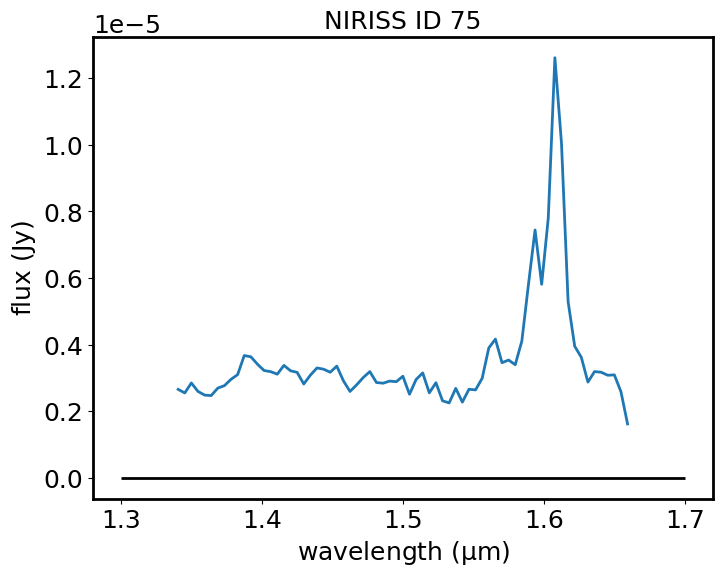

In [22]:
plt.plot(spectrum_sub.spectral_axis, spectrum_sub.flux)
plt.hlines(0, 1.3, 1.7, color='black')
plt.xlabel("wavelength ({:latex})".format(spectrum_sub.spectral_axis.unit))
plt.ylabel("flux ({:latex})".format(spectrum_sub.flux.unit))
plt.title("NIRISS ID 75")
plt.show()

<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/>